# Retrieving images from the BDGBP gene expression project
> Python code to retrieve metadata and images from the BDGP projects, and a first exploration of the dataset.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Thomas Sandmann
- categories: [BDGP, python]


The [BDGP project](https://insitu.fruitfly.org/cgi-bin/ex/insitu.pl?t=html&p=downloads)
shares metadata about the collected images as CSV files 

- [images](https://insitu.fruitfly.org/insitu-mysql-dump/insitu_images.csv.gz)
- [annotations](https://insitu.fruitfly.org/insitu-mysql-dump/insitu_annot.csv.gz)


In [39]:
image_metadata="https://insitu.fruitfly.org/insitu-mysql-dump/insitu_images.csv.gz"
image_annotations="https://insitu.fruitfly.org/insitu-mysql-dump/insitu_annot.csv.gz"

## Image metadata

In [110]:
from PIL import Image
from pathlib import Path
from io import BytesIO
import pandas as pd
import requests
import matplotlib.pyplot as plt

After some trial and error, I figured out that the CSV files are `latin1` encoded (e.g. not `UTF-8`). 
The provided files do not contain column names, so I added them myself.

In [137]:
images=pd.read_csv(image_metadata, header=None, compression="gzip",
                   encoding="latin1", index_col=False,
                   names=['id','symbol', 'annotation_symbol',
                          'FBgn', 'cDNA_clone', 'path', 'stage', 'pov',
                          'comment', 'resolution'])
annotations=pd.read_csv(image_annotations, header=None, compression="gzip",
                        encoding="latin1", index_col=False,
                        names=['id', 'annoation_symbol', 'FBgn', 'stage', 
                               'description'])

In [75]:
images.sample(5, random_state=123).style

,id,symbol,annotation_symbol,FBgn,cDNA_clone,path,stage,pov,comment,resolution
14685,CG1139,CG1139,CG1139,FBgn0035300,LP06969-dg,production_images/insituLP06969-dg_1.jpe,1,nan,nan,nan
114051,CG7263,AIF,AIF,FBgn0031392,FI05215,img_dir_179/insitu179269.jpe,6,lateral,nan,nan
1318,CG10072,sgl,sgl,FBgn0010851,SD09476,img_dir_10/insitu10741.jpe,6,lateral,AP_inverted,low
10732,CG11048,CG11048,CG11048,FBgn0034487,GH24459,img_dir_17/insitu17662.jpe,2,lateral,nan,low
73804,CG3297,mnd,mnd,FBgn0002778,LD25378-dg,img_dir_63/insitu63344.jpe,3,lateral,nan,low


In [76]:
annotations.sample(5, random_state=123).style

,id,annoation_symbol,FBgn,stage,description
29365,CG17158,cpb,FBgn0011570,5,procrystal cell
30863,CG17530,GstE6,FBgn0063494,6,embryonic dorsal epidermis
73387,CG6854,CG6854,FBgn0036478,6,embryonic/larval muscle system
70738,CG6417,Oatp33Eb,FBgn0032435,6,embryonic proventriculus inner layer
26431,CG1572,CG1572,FBgn0030309,6,ventral midline


The `stages` column indicates the 17
[developmental stages](http://flymove.uni-muenster.de/Stages/StgTabelle.html)
of *Drosophila melanogaster* development, binned as follows:

Stages     | Bin
-----------| ---
Stage 1-3  |  1
Stage 4-6  |  2															
Stage 7-8  |  3															
Stage 9-10 |  4																
Stage 11-12|  5																
Stage 13-16|  6

## Image files
The actual images should be available for download on the 
[BDGP FTP server](ftp://ftp.fruitfly.org/pub/insitu_image_storage),
but right now, that `pub` subdirectory does not contain the expected `insitu_image_storage` folder. I have contacted a BDGP Scientist and
asked for help locating it.

In the meantime, I can scrape images that are served via `http`.

For example, the following *thumbnail* image of a staining for transcripts of the *18w* gene is available at 
`https://insitu.fruitfly.org/insitu_image_storage/thumbnails/img_dir_101/insitu101409.jpe`

![18w thumbnail](https://insitu.fruitfly.org/insitu_image_storage/thumbnails/img_dir_101/insitu101409.jpe)

The full sized image can be found at 
`https://insitu.fruitfly.org/insitu_image_storage/img_dir_101/insitu101409.jpe`

![18w full sized image](https://insitu.fruitfly.org/insitu_image_storage/img_dir_101/insitu101409.jpe)

The path to the image files can be constructed from the shared root:

`https://insitu.fruitfly.org/insitu_image_storage/thumbnails/` and the `path` column in the image annotation CSV file.

For example, here are 10 randomly selected images:

In [138]:
root='https://insitu.fruitfly.org/insitu_image_storage/thumbnails/'
paths=images.sample(10, random_state=123).path.tolist()

def retrieve_image(root, path):
  url=root + path
  response = requests.get(url)
  return Image.open(BytesIO(response.content))

thumbnails=[retrieve_image(root, x) for x in paths]

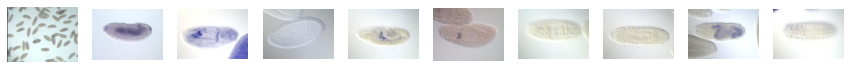

In [155]:
plt.figure(figsize=(15,4))

for num, x in enumerate(thumbnails):
    plt.subplot(1,len(thumbnails),num+1)
    plt.axis('off')
    plt.imshow(x)


The path to each image can be constructed by concatenating the FTP server's URL with the relative `path` provided in the image metadata file.